# Project Initialization

## Background


The goal for this project is to perform Time Series Forecasting on Air Pollution Dataset. We are given a training dataset to build your time series model, and to make prediction using the test dataset.

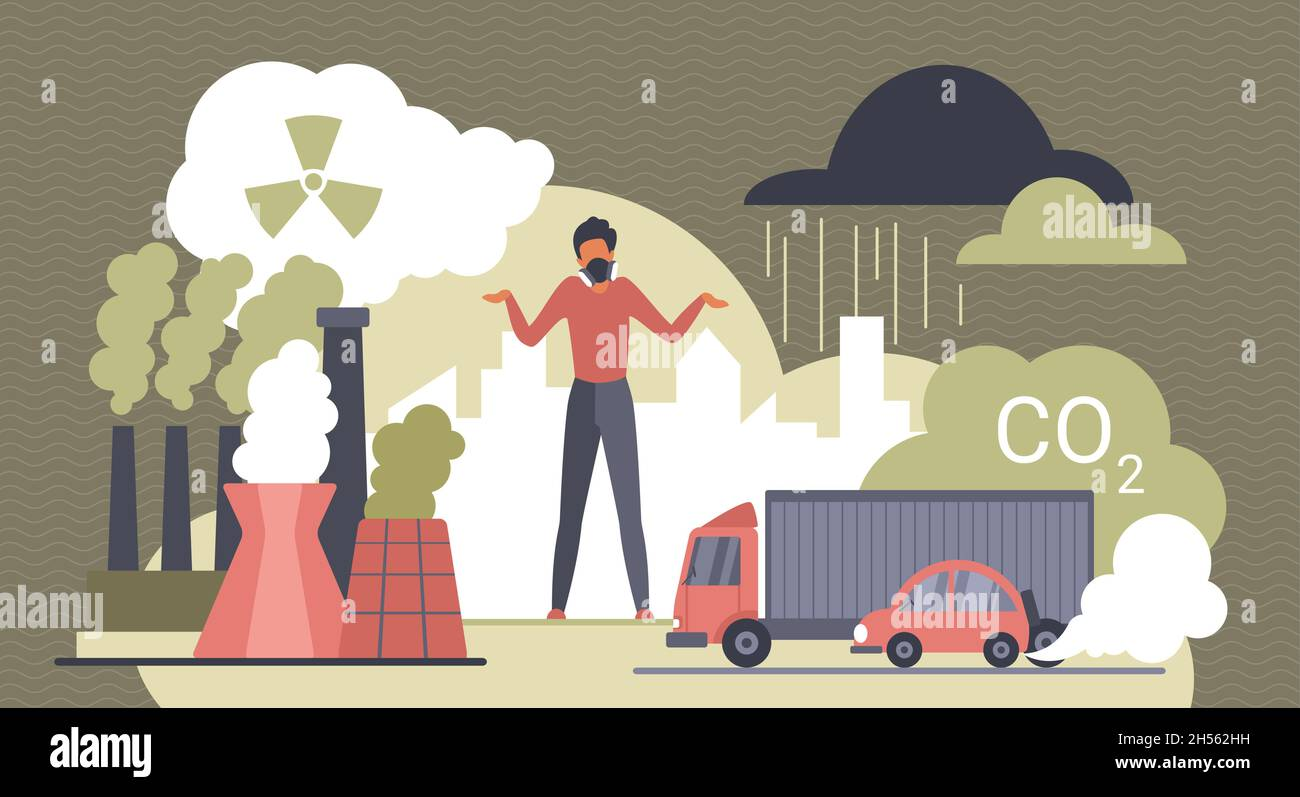

## Objective

> To forecast the Air Quality of Carbon Monoxide CO, Hydrocarbon(s) HC, Nitrous Dioxide NO2 and Ozone O3 for the next 63 Days(test size) using Univariate and Multivariate Statistical Model.

## Keywords


*   Time Series Forecasting
*   Seasonal Decomposition
*   Stationarity Testing
*   ACF + PACF
*   ARIMA
*   SARIMAX
*   VARMAX




## Dataset Background

After some digging, I found that the original source of the dataset is from  [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml//datasets/Air+quality). 

What's interesting is that they denoted:

> "Missing values are tagged with -200 value" 

The original dataset collected readings on a hourly basis. However, the data from dataset given is on a daily basis. After manually calculating certain rows,we can confirm that the daily readings are derived from averaging the 24hours of that particular day.

For now, we will keep this fact in mind and explore more on the implicaitons of missing values in the EDA process


## Load Dependencies

In [5]:
## General
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm

# Utility
from tqdm import tqdm # Track progress of a loop
import warnings # Ignore warnings
from statsmodels.tools.sm_exceptions import *
from collections import defaultdict 
from statsmodels.api import load # load serialized models
from joblib import Parallel, delayed # Parallelise our grid search
from IPython.display import display, HTML, Markdown

## Time Series
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt

## Model Validation
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error


# Graphical Plots
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sns.set()
plt.rcParams['figure.figsize'] = (13, 8)

## Load Train Dataset
Date formatting of the data does not follow the standard Pandas convention.
Therefore specift date formatting to convert date feature to Datetime

Time range for Train Dataset spans over 13 months from 03-2016 to 02-2017

In [2]:
df_raw = pd.read_csv('../Data/train.csv')
df_raw['Date'] = pd.to_datetime(df_raw['Date'], format="%d/%m/%Y") # Convert Date feature [Object --> Datetime]
display(df_raw)

,Date,T,RH,Gas,Value,Unnamed: 5,Unnamed: 6
0,2016-03-15,12.020833,54.883334,CO,1053.200000,NaN,NaN
1,2016-03-16,9.833333,64.069791,CO,995.250000,NaN,NaN
2,2016-03-17,11.292708,51.107292,CO,1025.250000,NaN,NaN
3,2016-03-18,12.866319,51.530903,CO,1064.444444,NaN,NaN
4,2016-03-19,16.016667,48.843750,CO,1088.741667,NaN,NaN
...,...,...,...,...,...,...,...
1307,2017-02-01,5.267708,39.614930,O3,553.180556,NaN,NaN
1308,2017-02-02,-55.515972,-24.010417,O3,343.500000,NaN,NaN
1309,2017-02-03,-14.272917,28.563542,O3,334.458333,NaN,NaN
1310,2017-02-04,4.848611,37.832986,O3,379.513889,NaN,NaN


# Exploratory Data Analysis

In our EDA for time series anaylsis on Air pollution dataset. We mainly focus on acomplishing the following: 

1. Visualize time series
1. Outlier + Missing Value analysis
2. Time series Decomposition
3. Strength of Trend and Seasonality of Gas values
4. Stationary Tests

## What is the timespan for this dataset?

In [3]:
print(f'Start Date:{df_raw["Date"].min()}\nEnd Date: {df_raw["Date"].max()}')

Start Date:2016-03-15 00:00:00
End Date: 2017-02-05 00:00:00


Conclusion:
Time range for Train Dataset spans over 13 months from 03-2016 to 02-2017

## Pre-eda processing: Datetime Index

Since we are given a panel data, a time series with more than one relative variable in the same period.

We will be creating a datetime index 

In [4]:
df_raw.set_index('Date', inplace=True)
display(df_raw)

,T,RH,Gas,Value,Unnamed: 5,Unnamed: 6
Date,,,,,,
2016-03-15,12.020833,54.883334,CO,1053.200000,NaN,NaN
2016-03-16,9.833333,64.069791,CO,995.250000,NaN,NaN
2016-03-17,11.292708,51.107292,CO,1025.250000,NaN,NaN
2016-03-18,12.866319,51.530903,CO,1064.444444,NaN,NaN
2016-03-19,16.016667,48.843750,CO,1088.741667,NaN,NaN
...,...,...,...,...,...,...
2017-02-01,5.267708,39.614930,O3,553.180556,NaN,NaN
2017-02-02,-55.515972,-24.010417,O3,343.500000,NaN,NaN
2017-02-03,-14.272917,28.563542,O3,334.458333,NaN,NaN


## Initial Time series Visualization

To give us a visual representation of our time series data

In [9]:
# plot time series data
features = ["T",	"RH",	"Value"]
fig = make_subplots(rows=3, cols=1)

for i, feature in enumerate(features):
    fig.add_trace(go.Scatter(x=df_raw.index, y=df_raw[feature], name=feature), row=i+1, col=1)
    # add name to subplots
    fig.update_yaxes(title_text=feature, row=i+1, col=1)
fig.update_layout(height=800, width=1200, title_text="Time Series analysis of Temperature, Relative Humidity and Value")
fig.show()

Observations: 


*   There is a consistent reoccurence in extreme negative values across T , RH and Value series. I.e When any features T, RH or Values spikes towards a negative values at a particular point in time all feautues will spike down at the datetime index
*   Value Series looks too clustered, with high variance in quantity.


Actions

* Further Analyse Drifting for extreme negative Values 
* check on Value and it's relationship with other variables
* Pivot Table on Value column

## Data Processing: Pivoting Table
The form of our data is in a long format. For easier analysis later, we will pivot the data to a wide format, with a column for each row turning every gas into its individual column. 

In [11]:
df_raw_pivot = pd.pivot(df_raw, values="Value", columns="Gas")
df_raw_pivot[["T", "RH"]] = df_raw[["T", "RH"]].groupby(df_raw.index).mean()

df_raw_pivot.head()

Gas,CO,HC,NO2,O3,T,RH
Date,,,,,,
2016-03-15,1053.200000,729.800000,933.800000,876.833333,12.020833,54.883334
2016-03-16,995.250000,681.441667,1021.750000,708.025000,9.833333,64.069791
2016-03-17,1025.250000,806.583333,881.375000,867.375000,11.292708,51.107292
2016-03-18,1064.444444,794.258333,794.527778,996.625000,12.866319,51.530903
2016-03-19,1088.741667,755.083333,800.883333,987.341667,16.016667,48.843750


## What's the frequency of time series data 

Is our dataset recorded every day?,every two days?,every week? or every month?

In [12]:
df_raw_pivot.index

DatetimeIndex(['2016-03-15', '2016-03-16', '2016-03-17', '2016-03-18',
               '2016-03-19', '2016-03-20', '2016-03-21', '2016-03-22',
               '2016-03-23', '2016-03-24',
               ...
               '2017-01-27', '2017-01-28', '2017-01-29', '2017-01-30',
               '2017-01-31', '2017-02-01', '2017-02-02', '2017-02-03',
               '2017-02-04', '2017-02-05'],
              dtype='datetime64[ns]', name='Date', length=328, freq=None)

From the looks of sameple index, it seems to be daily. We still will need to verify this


In [13]:
len(df_raw_pivot) - len(df_raw_pivot.asfreq("D"))

0

Since `.asfreq("D")` did not make any extra rows in the data, this confirms our hypothesis of a daily frequency

In [14]:
df_raw_pivot = df_raw_pivot.asfreq("D") # explicitly state a daily frequency

## Missing Values Analysis

After some digging, I found that the original source of the dataset is from  [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml//datasets/Air+quality). 

What's interesting is that they denoted:

> "Missing values are tagged with -200 value" 

Let's take a deeper analysis to check the implications when -200 on the Values of Gases

In [15]:
display(df_raw_pivot[df_raw_pivot['T'] == -200])

Gas,CO,HC,NO2,O3,T,RH
Date,,,,,,
2016-06-25,-160.0,-160.0,-160.0,-160.0,-200.0,-200.0
2016-09-01,-160.0,-160.0,-160.0,-160.0,-200.0,-200.0
2016-12-20,-160.0,-160.0,-160.0,-160.0,-200.0,-200.0
2016-12-21,-160.0,-160.0,-160.0,-160.0,-200.0,-200.0
2017-01-08,-160.0,-160.0,-160.0,-160.0,-200.0,-200.0
2017-01-09,-160.0,-160.0,-160.0,-160.0,-200.0,-200.0


Observations:

When Temperature `T` or `RH` have Values of -200, all the other gases will have values of -160

Conclusion:

Further Explore on these -200 and -160 values

In [38]:
def plot_ts(df,title):
    '''
    Funtion takes in a dataframe and plots the time series for all columns in the dataframe
    '''
    fig = make_subplots(rows= len(df.columns), cols=1, subplot_titles=df.columns)
    for i, feature in enumerate(df.columns):
        fig.add_trace(go.Scatter(x=df.index, y=df[feature], name=feature), row=i+1, col=1)
        # add name to subplots
        fig.update_yaxes(title_text=feature, row=i+1, col=1)
        fig.update_layout(height=800, width=1200, title_text=title)
    return fig

In [39]:
all_gases_ts = plot_ts(df_raw_pivot,title= "Time Series analysis of all gases seperately")
all_gases_ts.show()

**Observations**

*   There's interesting trend that when either one of the gasses are tagged with -160 value, the rest of the gasses will be -160 as well
*   The extreme values seems to appear randomly with no pattern

One possible hypothesis is that the spikes indicate some problem with the sensor used, and thus, the sensors had to be sent for repairs, causing data to be unavailable in the meantime. This would indicate why all the sensors had missing datas on those days.

**Action**

*    Interpolate the missing value using instead of dropping it.


## Data Processing: Interpolatation on *"Missing"* values

In [64]:

# Replace Gases Values -160 and Temperature/RH values -200 with Null
df_pivot_impute = df_raw_pivot[['CO','HC','NO2','O3','T','RH']].replace({-160: np.NaN,-200: np.NaN}) # Replace Gases Values -160 and Temperature/RH values -200 with Null
print("\nNumber of Missing Rows after Replace with NULL : \n{}".format(df_pivot_impute.isnull().sum()))

# Interpolate missing values
df_pivot_impute = df_pivot_impute.interpolate(method='linear', limit_direction='forward', axis=0)
print("\nNumber of Missing Rows after interpolation: \n{}".format(df_pivot_impute.isnull().sum()))



Number of Missing Rows after Replace with NULL : 
Gas
CO     6
HC     6
NO2    6
O3     6
T      6
RH     6
dtype: int64

Number of Missing Rows after interpolation: 
Gas
CO     0
HC     0
NO2    0
O3     0
T      0
RH     0
dtype: int64


In [52]:
# Re-plot Time Series after interpolation
all_gases_after_interpolation = plot_ts(df_pivot_impute,title= "Time Series analysis of all gases seperately after interpolation")
all_gases_after_interpolation.show()

Observation:

There is still occurance of extreme values seems to appear randomly with no pattern. E.g `RH` on Apr 14 2016 with `RH` of -188 which doesn't make sense as Relative Humidity is calculated as a percentag. Percentages cannot be negative 

Conclusion:

Further Explore on these drifted extreme value

## Extreme Values analysis

After imputing the missing values -200 and -160 as NaN.

The minumum values for Temperature is still -191 degrees, which is ilogical for climate in Italy ( which the dataset was taken from )

Furthermore Relative Humidity percentage metric, thus even more ilogical for percentage to be negative



---
After digging around the orginal dataset FROM UCI repository, and comparing it with the given dataset, I found out that when the school merged the hourly readings from the original dataset, they merged days that certain contains both missing and actual readings per hour

As a result if just 1hour out of the 24 hours in a day had actual readings the averaged value will be slightly lower than -200 OR < -160 for gases

We will call these extreme values drifted missing values

In [53]:
df_pivot_impute.min()

Gas
CO    -114.133333
HC    -122.766667
NO2   -124.466667
O3    -114.958333
T     -191.164583
RH    -188.839583
dtype: float64

### Imputing drifted missing values

From background research of origns of data collection to be Italy. The lowest recorded temperature in Italy is found to be **-49.6 °C** 

Therefore, We will use a threshold value of `T` < -49 OR `RH` < 0 ( AKA negative percentage for RH which makes no sense ) to extract all partically affected missing value ( as explained above )

In [65]:
# Create Boolean Column to Indicate Drifting when Temperature is less than -49 OR RH < 0 (Abnormal)

df_pivot_impute['Drift'] = (df_pivot_impute['T'] < -49) | (df_pivot_impute['RH'] < 0)

# Extract drift rows
df_pivot_impute[df_pivot_impute['Drift'] == True]

Gas,CO,HC,NO2,O3,T,RH,Drift
Date,,,,,,,
2016-04-14,-114.133333,-122.766667,-124.466667,-114.958333,-191.164583,-188.839583,True
2016-05-30,598.225000,569.850000,623.550000,557.075000,-23.920833,-24.786458,True
2016-05-31,489.027778,530.961111,480.750000,514.877778,-57.951736,-61.500694,True
2016-06-24,385.402778,326.963889,362.972222,305.705556,-68.069792,-58.296875,True
2016-06-25,496.197222,478.977778,461.769444,412.823611,-40.109375,-31.856771,True
2016-06-26,606.991667,630.991667,560.566667,519.941667,-12.148958,-5.416667,True
2016-08-31,48.866667,14.841667,82.016667,-0.975000,-144.072917,-138.672917,True
2016-09-01,345.833333,285.170833,324.454167,246.183333,-72.343229,-64.682812,True
2016-09-13,180.166667,182.550000,92.991667,228.008333,-133.732292,-133.684375,True


### Visualizing Drifted values

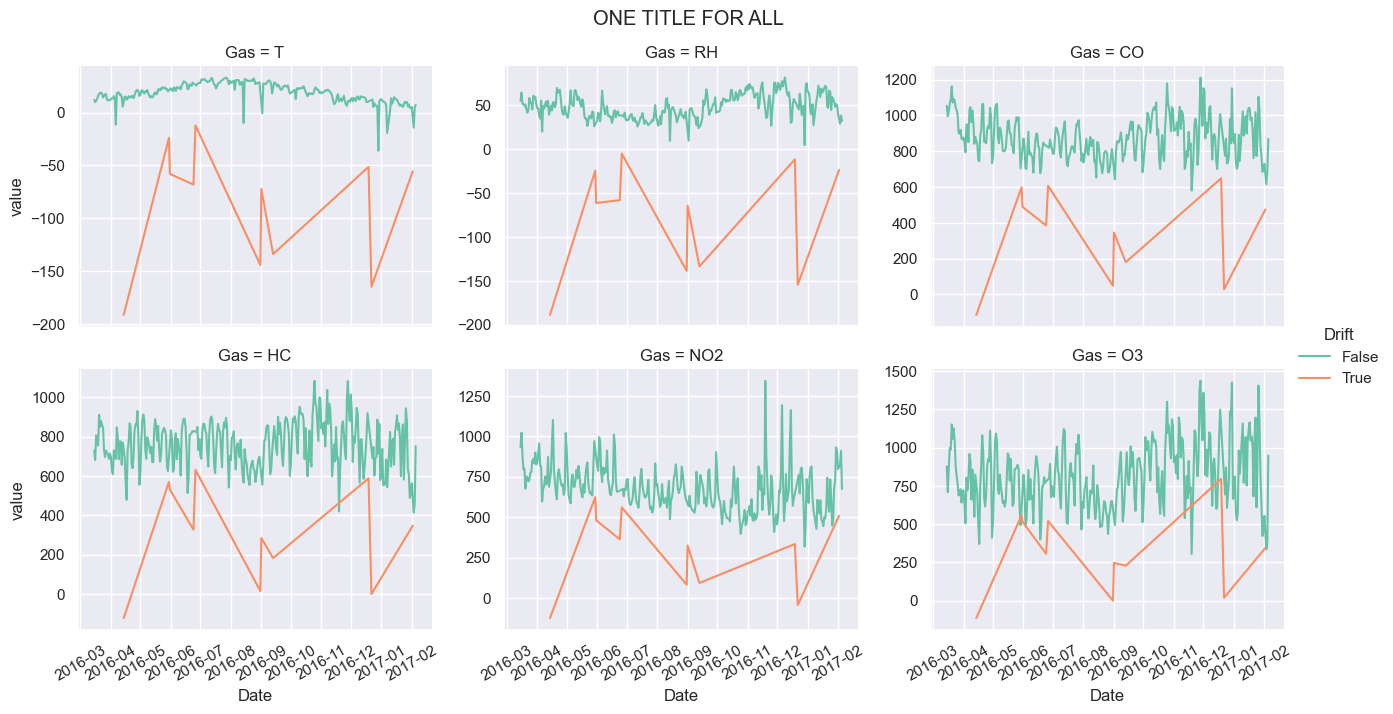

In [56]:
g = sns.FacetGrid(
        pd.melt(
            df_pivot_impute, 
            id_vars='Drift', 
            value_vars=['T', 'RH', 'CO','HC','NO2','O3'], 
            ignore_index=False).reset_index(), 
        col="Gas", 
        hue = 'Drift',
        palette="Set2",
        col_wrap= 3,
        sharey=False,
        height=3.5,
        aspect=1.25
    )
g.map(sns.lineplot, "Date", "value", estimator = None)
g.set_xticklabels(rotation=30)
#add legend
g.add_legend()
g.fig.subplots_adjust(top=0.9) # adjust the Figure in g
g.fig.suptitle('ONE TITLE FOR ALL')

plt.show()

Observations: 
* Using only `T` and `RH` as the indicator to a drifting, we can see similar drifted values from all other `gas` values. Indicating, when either temperature or RH sensors is faluty, the sensors all the gases become faluty as well
* It seems like drifting values appear randomly following no repeated pattern

**Action**

Interpolate all values for drifted data

## Data Processing: Interpolatation on *"Drifted"* values

In [66]:
# Replace Drifting Values with Null
df_pivot_impute.loc[df_pivot_impute['Drift']] = np.nan
print("\nNumber of Missing Rows after drifted values Replace with NULL : \n{}".format(df_pivot_impute.isnull().sum()))

df_pivot_impute = df_pivot_impute.interpolate(method='linear', limit_direction='forward', axis=0)
print("\nNumber of Missing Rows after interpolated drifted values: \n{}".format(df_pivot_impute.isnull().sum()))
df_pivot_impute.drop(columns= 'Drift', inplace = True)



Number of Missing Rows after drifted values Replace with NULL : 
Gas
CO       14
HC       14
NO2      14
O3       14
T        14
RH       14
Drift    14
dtype: int64

Number of Missing Rows after interpolated drifted values: 
Gas
CO        0
HC        0
NO2       0
O3        0
T         0
RH        0
Drift    14
dtype: int64


In [67]:
final_ts = plot_ts(df_pivot_impute,title= "Time Series analysis of all gases seperately after interpolation and drift removal")
final_ts.show()


Observations:

Succesfully removed extreme outliers and time series looks much cleaner

# Seasonal Decomposition

Time series data usually exhibit different kinds of patterns, which can be broken down into components of Time Series to understand our data better.

* Trend component: 
  > Trend shows whether the data tends to increase or decrease on a average, long-term, smooth tendency.
* Seasonality component: 
> Variation in varible due to some predetermined patterns over the same period of time

* Cyclical component:
> In which there is no fixed interval, uncertainty in movement and its pattern

* Irregularity: 
> Unexpected situations/events/scenarios and spikes in a short time span.

There are two ways which we can decompose our data.

**Additively** ($y_t = S_t + T_t + R_t$), or **multiplicatively** ($y_t = S_t \times T_t \times R_t$).

From our initial TS plot, we can see that variance does not change as the mean changes. Therefore, we will choose to use an additive model for decomposition

---

Seasonal Decomposition
Column: CO
Seasonal 7


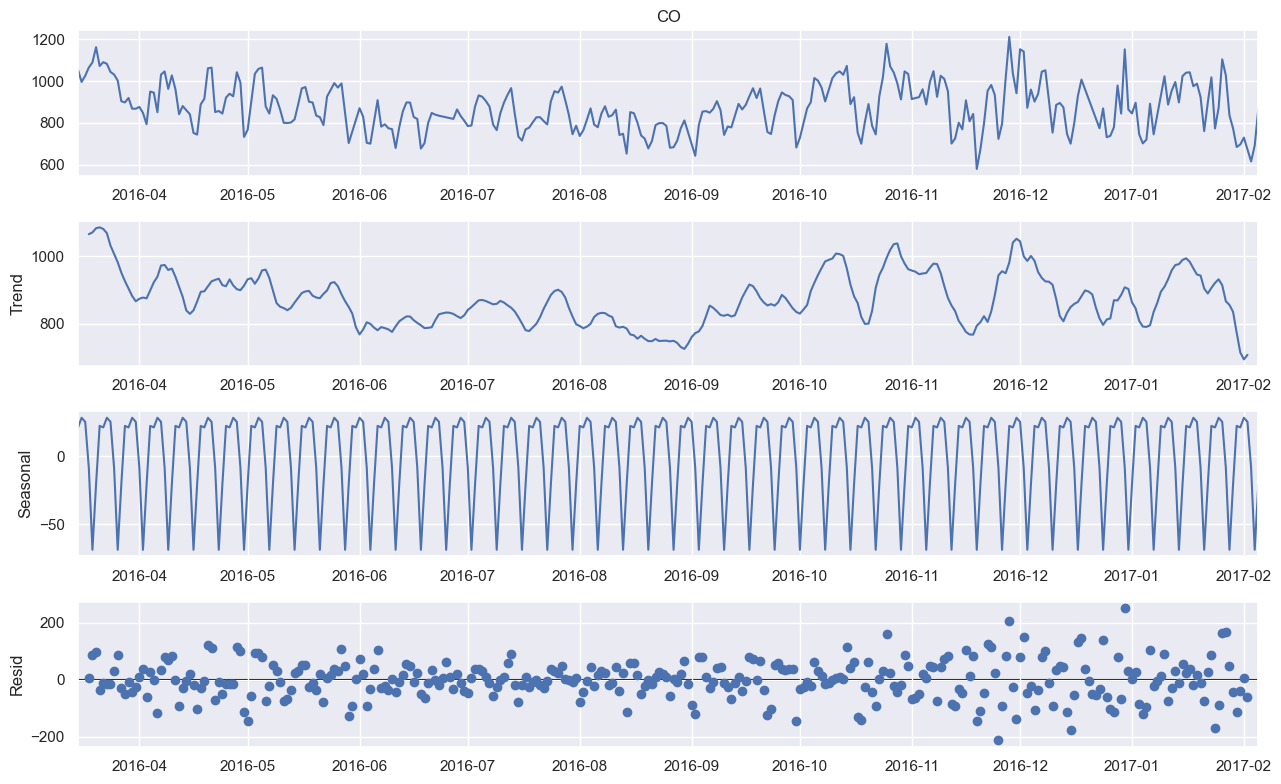

---

Seasonal Decomposition
Column: HC
Seasonal 7


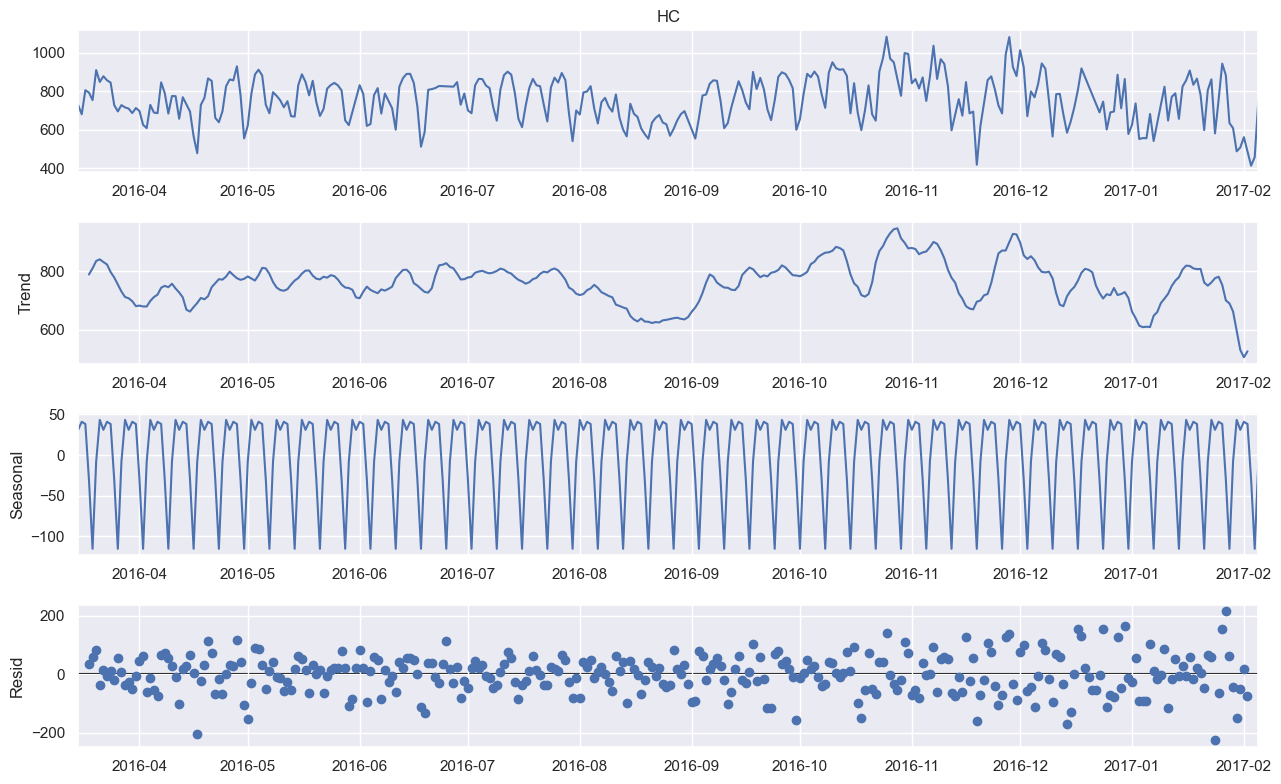

---

Seasonal Decomposition
Column: NO2
Seasonal 7


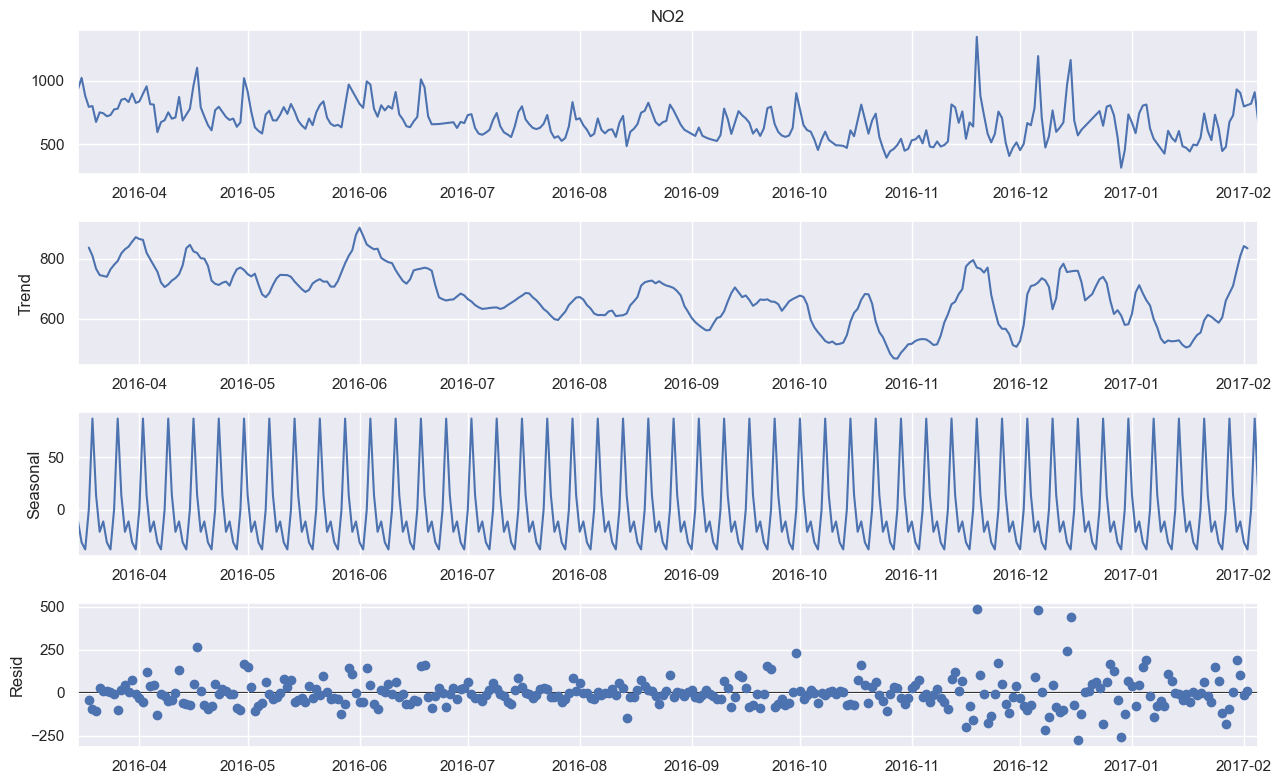

---

Seasonal Decomposition
Column: O3
Seasonal 7


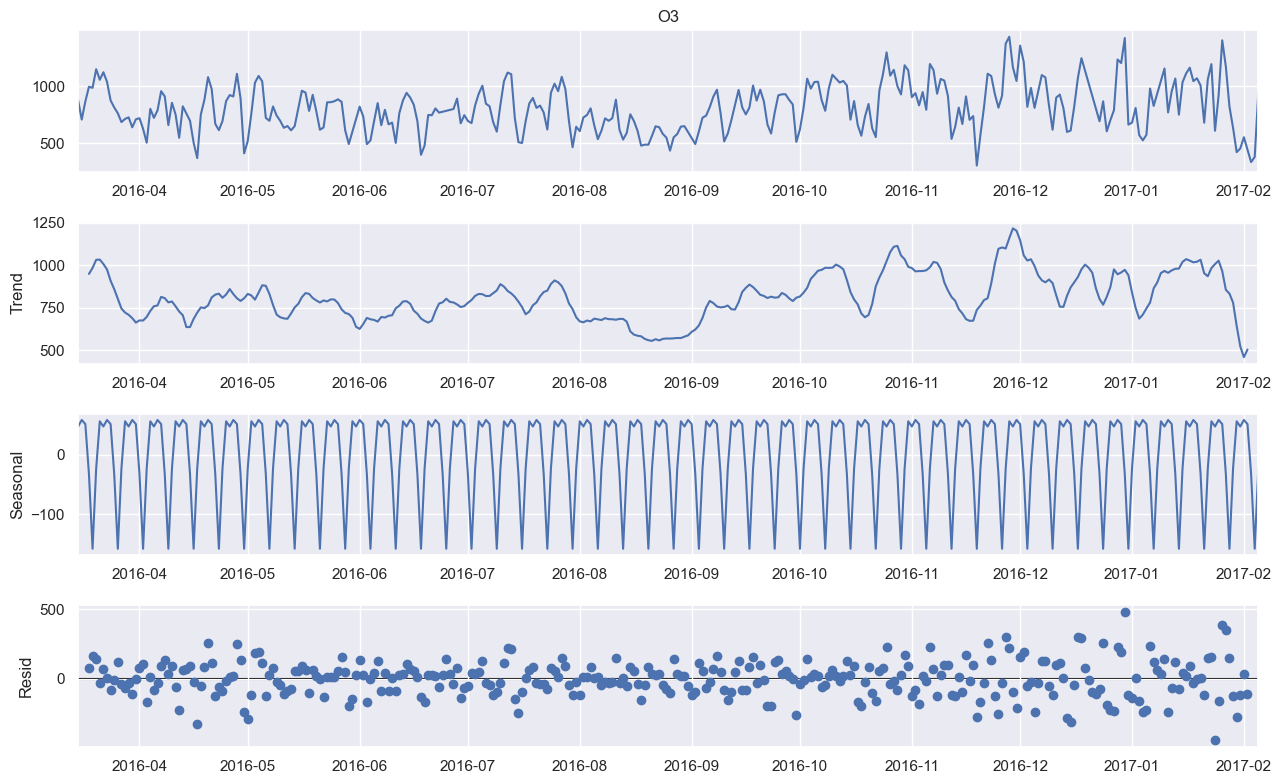

---

Seasonal Decomposition
Column: T
Seasonal 7


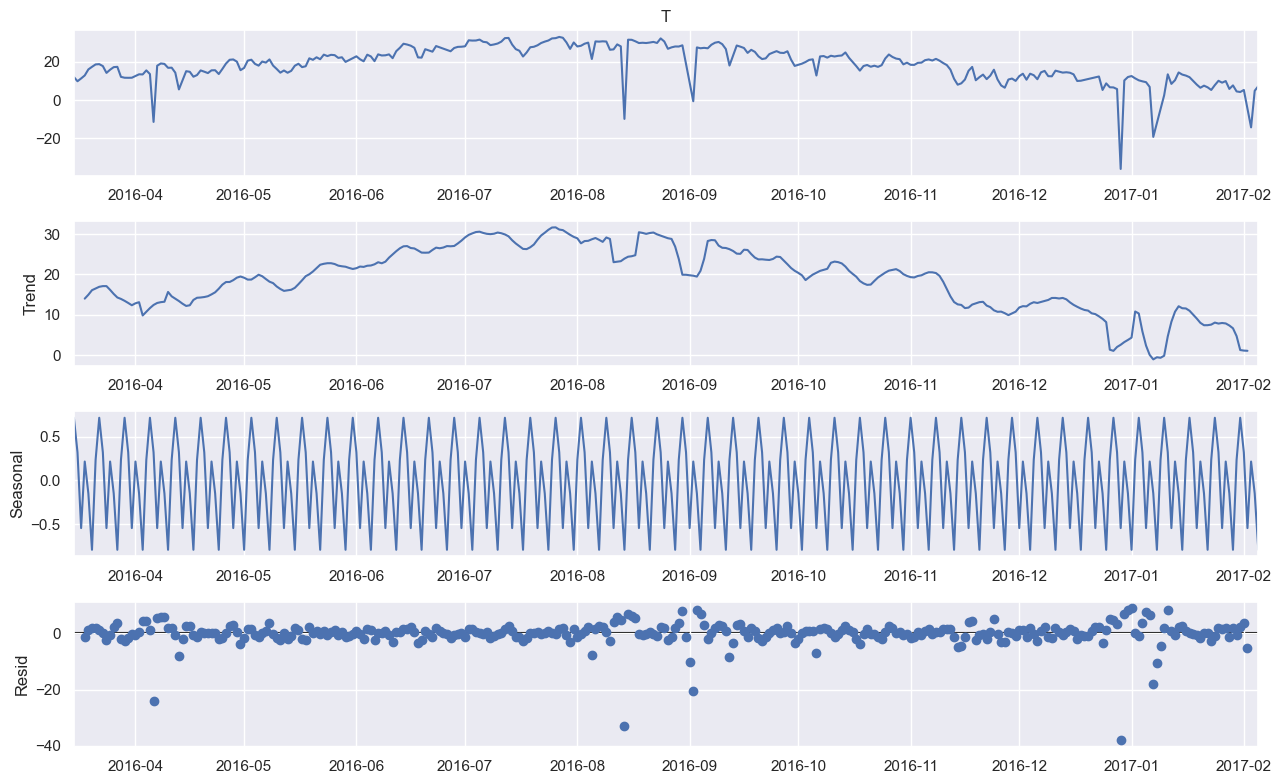

---

Seasonal Decomposition
Column: RH
Seasonal 7


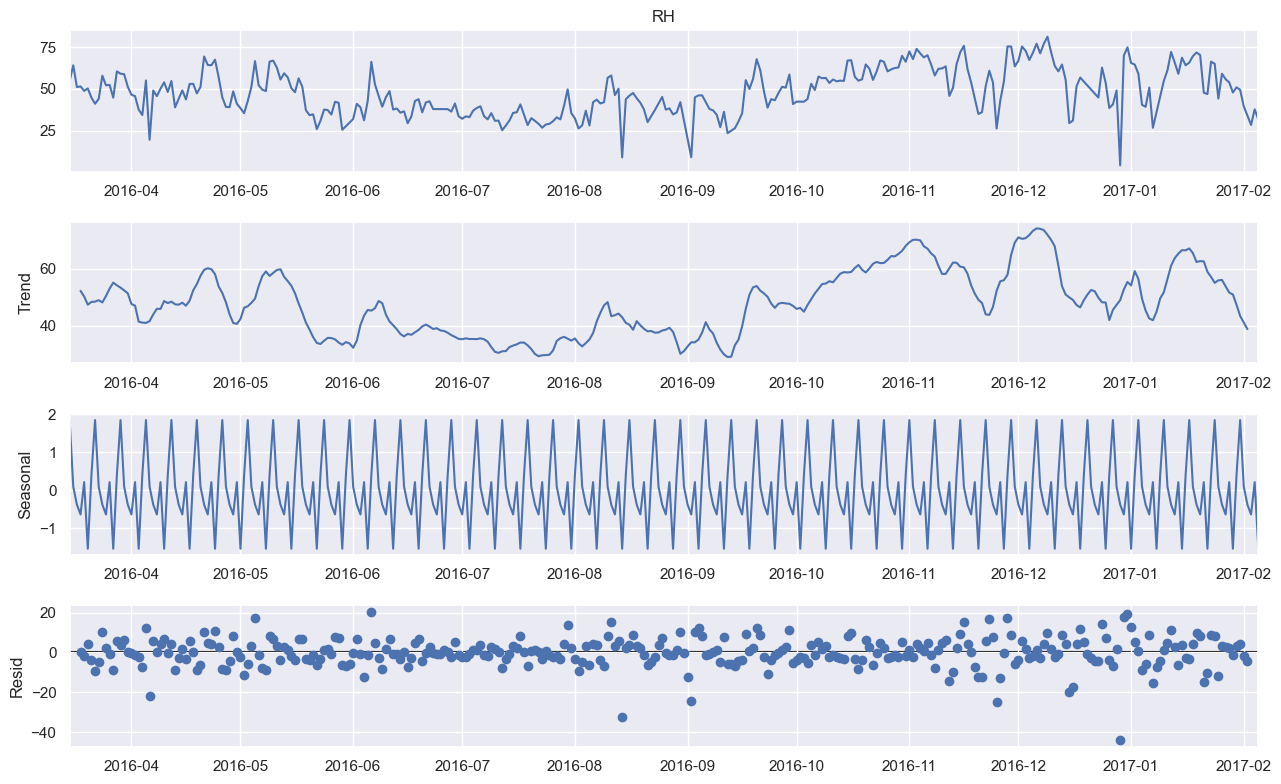

---

In [72]:
from statsmodels.tsa.seasonal import seasonal_decompose

# seasonal decomposition
display(Markdown('---'))
for i in df_pivot_impute.columns:
    print('Seasonal Decomposition\nColumn:', i)
    decomposition = seasonal_decompose(df_pivot_impute[i])
    print('Seasonal', len(decomposition.seasonal.drop_duplicates()))
    decomposition.plot()
    plt.show()
    display(Markdown('---'))

Observation:

* Strong seasonality for all *Gas* variables and even T and RH. with there being a cycle that seemingly corresponds to 7 days AKA weekly

* 

Conclustion:

* Models that account for seasonality like SARIMA/SARIMAX might perform well on our data

# Stationary test

Knowing if our data is stationary is neccessary as having Stationary data one of the statistical assumptions that may be made by our models any (AR MA models)

Stationary data represents  **mean, variance and covariance does not vary with time.**

There are two statistical test we can perform to check for stationary data


*   Augmented Dickey-Fuller Test ( ADF )
*   Kwiatkowski-Phillips-Schmidt-Shin (KPSS)

We will choose to apply/run both the tests and makes sure that the series is truly stationary


## ADF test for stationary

To verify stationarity, we will be utilising Augmented Dickey Test at Significant Value, $p=0.05$ with,
$$
H_0 : \text{Time-Series is Non-Stationary,there is a unit root} \\
H_1 : \text{Time-Series is Stationary, there is no unit root} 
$$

[Reference: Statsmodels](https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html)


In [68]:
significance_level = 0.05
for feature in df_pivot_impute.columns:
    print(f'\n{feature}')
    print(f"Test for Stationarity\nSignificance Level: {significance_level}\nH0: Time-Series is Non-Stationary,there is a unit root \nH1: Time-Series is Stationary,there is no unit root ")
    test_statistic, pvalue, usedlag, *_ = adfuller(df_pivot_impute[feature])
    print(f"P-value: {pvalue:.3f}")
    print(f"Used Lag: {usedlag}")
    if pvalue < significance_level:
        print("Reject H0. There is evidence that the time series is stationary.")
    else:
        print("Fail to reject H0. There is insufficient evidence that the time series is stationary.")
    display(test_statistic, pvalue, usedlag)


CO
Test for Stationarity
Significance Level: 0.05
H0: Time-Series is Non-Stationary,there is a unit root 
H1: Time-Series is Stationary,there is no unit root 
P-value: 0.000
Used Lag: 8
Reject H0. There is evidence that the time series is stationary.


-4.57582308292521

0.00014309276640566118

8


HC
Test for Stationarity
Significance Level: 0.05
H0: Time-Series is Non-Stationary,there is a unit root 
H1: Time-Series is Stationary,there is no unit root 
P-value: 0.014
Used Lag: 14
Reject H0. There is evidence that the time series is stationary.


-3.319541887275797

0.014027231656534777

14


NO2
Test for Stationarity
Significance Level: 0.05
H0: Time-Series is Non-Stationary,there is a unit root 
H1: Time-Series is Stationary,there is no unit root 
P-value: 0.001
Used Lag: 6
Reject H0. There is evidence that the time series is stationary.


-4.025192241515697

0.0012841927276947942

6


O3
Test for Stationarity
Significance Level: 0.05
H0: Time-Series is Non-Stationary,there is a unit root 
H1: Time-Series is Stationary,there is no unit root 
P-value: 0.017
Used Lag: 12
Reject H0. There is evidence that the time series is stationary.


-3.261589369051062

0.01668520132259037

12


T
Test for Stationarity
Significance Level: 0.05
H0: Time-Series is Non-Stationary,there is a unit root 
H1: Time-Series is Stationary,there is no unit root 
P-value: 0.865
Used Lag: 10
Fail to reject H0. There is insufficient evidence that the time series is stationary.


-0.6245807540372383

0.8653304937565434

10


RH
Test for Stationarity
Significance Level: 0.05
H0: Time-Series is Non-Stationary,there is a unit root 
H1: Time-Series is Stationary,there is no unit root 
P-value: 0.000
Used Lag: 2
Reject H0. There is evidence that the time series is stationary.


-4.842786849897102

4.501186693447349e-05

2

ADF Observations:

*   All Gases `CO`,`HC`, `NO2` and `O3` time series are stationary at $p=0.05$ 
*   Only `T` temperature does not appear to be stationary 

## KPSS test for stationary

Kwiatkowski-Phillips-Schmidt-Shin (KPSS) similar to ADF in that it also tests for the stationarity of time series.

#### How is KPSS test different from ADF test?

KPSS test has the capability to check for stationarity in the *presence of a deterministic trend*. Impliying the slope of the trend in the series does not change permanently. That is, even if the series goes through a shock, it tends to regain its original path.

$$
H_0 : \text{Time-Series is Non-Stationary,there is a unit root} \\
H_1 : \text{Time-Series is Stationary, there is no unit root} 
$$

[References: Machine Learning+ KPSS Test for Stationarity](https://www.machinelearningplus.com/time-series/kpss-test-for-stationarity/#:~:text=In%20python%2C%20the%20statsmodel%20package,the%20opposite%20to%20each%20other.)

In [69]:
def KPPS_test(df, significance_level = 0.05, columns = ['CO', 'HC', 'NO2', 'O3', 'T', 'RH'],diff=False):
  for feature in columns:
    with warnings.catch_warnings():
      warnings.simplefilter("ignore")
      if diff:
        print(f'\n{feature},difference=1')
      else:
        print(f'\n{feature}')
      print(f"Test for Stationarity\nSignificance Level: {significance_level}\nH0: Process is trend stationary \nH1: There is a unit root (non-stationary)")
      if diff:
        test_statistic, pvalue, usedlag, *_ = kpss(df[feature].diff().dropna(), regression="c", nlags="auto")
      else:
        test_statistic, pvalue, usedlag, *_ = kpss(df[feature], regression="c", nlags="auto")
      print(f'KPSS Statistic: {test_statistic}')
      print(f"P-value: {pvalue:.3f}")
      print(f"Used Lag: {usedlag}")
      if pvalue < significance_level:
          print("Reject H0. There is evidence that the time series is not stationary.")
      else:
          print("Fail to reject H0. There is insufficient evidence that the time series is not stationary.")
      display(test_statistic, pvalue, usedlag)

In [70]:
KPPS_test(df_pivot_impute)


CO
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary 
H1: There is a unit root (non-stationary)
KPSS Statistic: 0.2693834204074792
P-value: 0.100
Used Lag: 9
Fail to reject H0. There is insufficient evidence that the time series is not stationary.


0.2693834204074792

0.1

9


HC
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary 
H1: There is a unit root (non-stationary)
KPSS Statistic: 0.14994490675957448
P-value: 0.100
Used Lag: 7
Fail to reject H0. There is insufficient evidence that the time series is not stationary.


0.14994490675957448

0.1

7


NO2
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary 
H1: There is a unit root (non-stationary)
KPSS Statistic: 1.3944454038527225
P-value: 0.010
Used Lag: 8
Reject H0. There is evidence that the time series is not stationary.


1.3944454038527225

0.01

8


O3
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary 
H1: There is a unit root (non-stationary)
KPSS Statistic: 0.6928927562984605
P-value: 0.014
Used Lag: 8
Reject H0. There is evidence that the time series is not stationary.


0.6928927562984605

0.014191567609230864

8


T
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary 
H1: There is a unit root (non-stationary)
KPSS Statistic: 1.2240681920172252
P-value: 0.010
Used Lag: 10
Reject H0. There is evidence that the time series is not stationary.


1.2240681920172252

0.01

10


RH
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary 
H1: There is a unit root (non-stationary)
KPSS Statistic: 0.8796570309740344
P-value: 0.010
Used Lag: 10
Reject H0. There is evidence that the time series is not stationary.


0.8796570309740344

0.01

10

KPSS Observations:

*   Only Gases `CO` and `HC` time series are **stationary** at $p=0.05$ 
*   Gases `NO2` and `O3` time series is **not stationary** at $p=0.05$ 
*   Both `T` and `RH` time series is **not stationary** at $p=0.05$ 

## Final Conclusiton for stationary test


1.   Time series for Gases `CO` and `HC`: Both tests conclude that the given series is stationary – These two series is stationary


> No differencing needed


2.  Time series for Gases `NO2` and `O3`: **ADF concludes stationary and KPSS concludes non-stationary** – These two series is difference stationary.

> Differencing is to be used to make series stationary. Then the differenced series is checked for stationarity.

3. Time series for `T`: Both tests conclude that the given series is non-stationary – The series is non-stationary

4. Time series for `RH`: ADF concludes stationary and KPSS concludes non-stationary – The series is difference stationary.

[Reference: Statistical tests to check stationarity in Time Series](https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/#:~:text=In%20python%2C%20the%20statsmodel%20package,the%20opposite%20to%20each%20other.)


In [71]:
# Re-run KPPS Test for NO2 and O3 when differenced by 1
KPPS_test(df_pivot_impute,columns=['NO2','O3'],diff=True)


NO2,difference=1
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary 
H1: There is a unit root (non-stationary)
KPSS Statistic: 0.22753781203144954
P-value: 0.100
Used Lag: 86
Fail to reject H0. There is insufficient evidence that the time series is not stationary.


0.22753781203144954

0.1

86


O3,difference=1
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary 
H1: There is a unit root (non-stationary)
KPSS Statistic: 0.08785184740065698
P-value: 0.100
Used Lag: 46
Fail to reject H0. There is insufficient evidence that the time series is not stationary.


0.08785184740065698

0.1

46

Conclusion:

After differencing `NO2` and `O3` by period=1 

KPPS test concluded time series stationary

# Pre work for AR/MA 

## Auto-Correlation & Partial Auto-Correlation Plot (ACF, PACF)

We will be using ACF and PACF plots to helps detect patterns and check for randomness in our time series data.

Using the ACF plot we want to answer the following questions:

* Is the observed time series white noise/random?
* Is an observation related to an adjacent observation, an observation twice-removed, and so on?
* Can the observed time series be modeled with an MA model? If yes, what is the order?

PACF to answer:

* Can the observed time series be modeled with an AR model? If yes, what is the order?

[References](https://towardsdatascience.com/interpreting-acf-and-pacf-plots-for-time-series-forecasting-af0d6db4061c)

ACF and PACF plots assumes stationary data, thus we will have to difference data for `NO2` and `O3` to make time series stationary before passing to ACF & PACF  

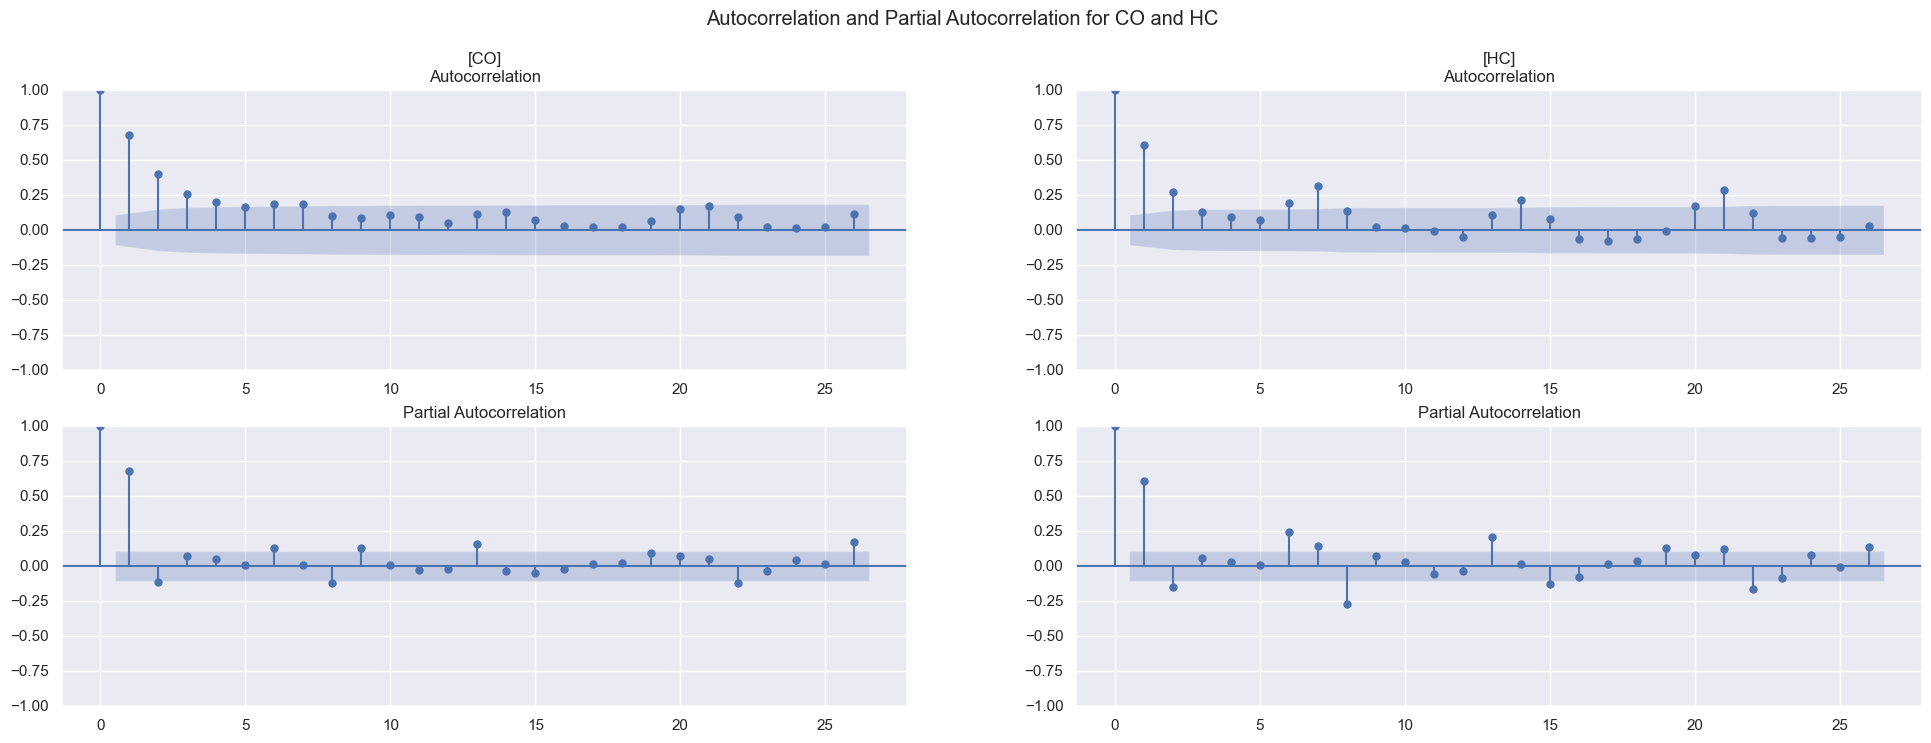

In [77]:
# Plot ACF for CO, HC
target_features = ['CO', 'HC']

fig, axes = plt.subplots(2,2, figsize = (24,8))
for idx, variable in enumerate(target_features):
    plot_acf(df_pivot_impute[variable],  ax = axes[0, idx]) # Looks for MA(q)
    plot_pacf(df_pivot_impute[variable], ax = axes[1, idx]) # Looks for AR(p)
    axes[0, idx].set_title("[{}]\nAutocorrelation".format(variable))
# set main title
fig.suptitle("Autocorrelation and Partial Autocorrelation for CO and HC")
plt.show()


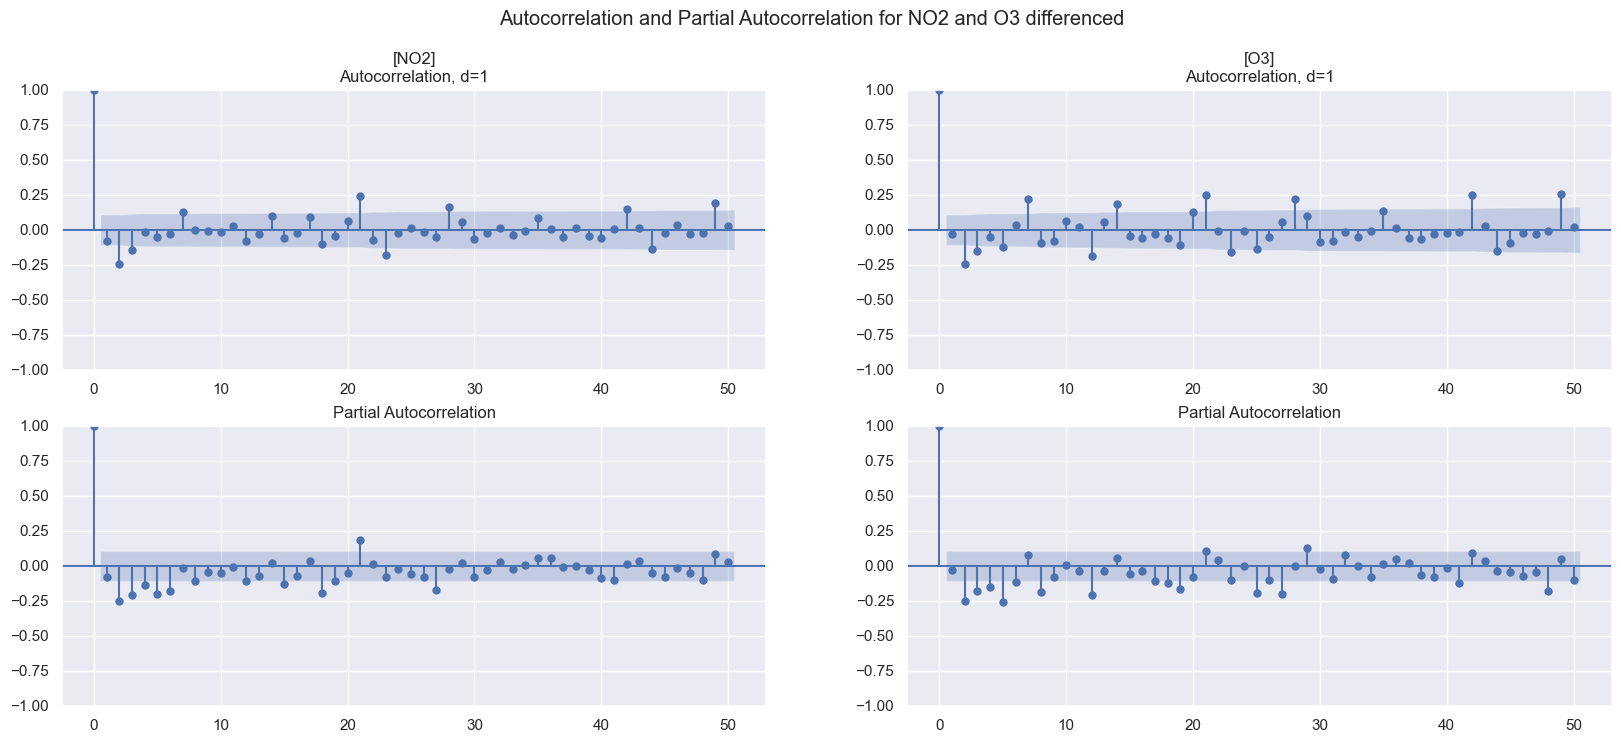

In [79]:
# Difference NO2 and O3 before plotting ACF and PACF
target_features = ['NO2', 'O3']

fig, axes = plt.subplots(2,2, figsize = (20,8))
for idx, variable in enumerate(target_features):
    plot_acf(df_pivot_impute[variable].diff().dropna(), lags = 50, ax = axes[0, idx]) # Difference in NO2 
    plot_pacf(df_pivot_impute[variable].diff().dropna(), lags = 50, ax = axes[1, idx]) # Looks for AR(p)
    axes[0, idx].set_title("[{}]\nAutocorrelation, d=1".format(variable))
# set main title
fig.suptitle("Autocorrelation and Partial Autocorrelation for NO2 and O3 differenced")
plt.show()

Observation:

For all gases `CO`,`HC`, `NO2` and `O3`:

*   There are several autocorrelations that are significantly non-zero. Therefore, the time series is non-random.

**Observation Summary**

| Gasses | AR(p significant lags) | MA(q significant lags) | Remarks | Potential Initial Model |
| ---    | ---   | ---   | :---                                   | :---    |
| CO     | 2     | 3   | Weak Seasonal Trend every 7 Iteration| MA(3)/ AR(2)/ ARMA(2,3)/SARIMA(2,0,3)(1,0,1,7) |
| HC   | 2     | 3     | Seasonal Trend every 7 Iteration | MA(3)/ AR(2)/ ARMA(2,3)/ SARIMA(2,0,3)(2,0,1,7)
| NO2    | 2     | 1     | Weaj Seasonal Trend every 13 iterations    | MA(1)/ AR(2)/ ARMA(2,2)/SARIMA(2,1,1)(2,1,1,13) |
| O3     | 2     | 1     | Seasonal Trend every 7 Iteration | MA(1)/ AR(2)/ ARMA(2,3)/SARIMA(2,1,1)(1,1,1,7)

# Model Evaluate

for all gases
* Train RMSE
* Test RMSE 
* AIC

Model plot digonstics

In [81]:
def modelEvaluation(model,endog,exog=None,tscv=TimeSeriesSplit(n_splits=3,test_size=63),test_size=63,target_features=[],curve=True,**kwargs):
  '''
  Function takes in a model, endog variable/exog variable(if any) 
  '''
  results = defaultdict(list)
  for idx, (train_idx,test_idx) in enumerate(tscv.split(endog)): # Expanding Window 
    if exog is not None:
      train_exog = exog.iloc[train_idx]
      test_exog = exog.iloc[test_idx]
    else:
      train_exog =None
      test_exog = None

    train_fold = endog.iloc[train_idx]
    test_fold = endog.iloc[test_idx]

    # display(train_exog)
    # display(train_fold)
    if exog is not None:
      res = model(train_fold, exog.iloc[train_idx], **kwargs).fit()
      print(res.summary())
      train_predict = res.predict(train_fold.index[0],train_fold.index[-1],exog=train_exog)
      test_predict = res.predict(start=test_fold.index[0],end=test_fold.index[-1],exog=test_exog)

    else:
      res = model(train_fold,**kwargs).fit()
      train_predict = res.predict(train_fold.index[0],train_fold.index[-1])
      # train_predict = res.forecast(len(train_idx))
      test_predict = res.predict(start=test_fold.index[0],end=test_fold.index[-1])

    # test_predict = res.predict(start=test_fold.index[0],end=test_fold.index[-1])

    rmse_train = mean_squared_error(train_fold, train_predict,squared=False) # Get train rmse for each split
    results['Train RMSE'].append(rmse_train)
    rmse_test = mean_squared_error(test_fold,test_predict,squared=False) # Get test rmse for each split
    results['Test RMSE'].append(rmse_test)
    results['Difference in RMSE'].append(rmse_train - rmse_test)
    results['AIC'].append(res.aic)

    print(f'this is idx:{idx}')
    if curve and idx==2 : # Only plot TS for last fold 
      axes[idx//2, idx%2].set_title("[{}]\nRMSE:{}".format(
        target_features[idx], rmse_test))
      axes[idx//2, idx%2].plot(endog, label = 'Actual', alpha=0.5)
      axes[idx//2, idx%2].plot(train_predict, label = 'Train', alpha=0.9)
      axes[idx//2, idx%2].plot(test_predict, label='Test', alpha=0.9)     
  # results['Train RMSE'] = np.array(['Train RMSE']).mean()
  # display(results)
  return res , results


### Organise Results

In [82]:
Total_history = pd.DataFrame(columns=['Model Name', 'Mean Test RMSE', 'Difference in RMSE', 'Gas'])

def addHistory(model_name,cv_metrics,gas,past_history):
    cur_result = pd.Series({
        "Model Name" : model_name,
        "Mean Test RMSE" : np.mean(cv_metrics['Test RMSE']),
        'Difference in RMSE' : np.mean(cv_metrics['Difference in RMSE']),
        # "Final AICc" : np.mean(cv_metrics['Final AICc']),
        "Gas" : gas
    })
    history = past_history.append(cur_result, ignore_index=True)
    return history

### Analysise results

In [83]:
def parse_results(results):
    cols = [pd.DataFrame(results[col]) for col in results.keys()]
    # display(cols)
    return pd.concat(cols, axis=1, keys=results.keys())

# ARIMA Model

In [84]:
ARIMA_Results = defaultdict(list)

target_features = ['CO', 'HC', 'NO2', 'O3']
# target_features = ['CO']

orders = {
    "CO" : (2,0,3),
    "HC" : (2,0,3),
    "NO2" : (2, 1, 1),
    "O3" : (2, 1, 1)
}
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    for gas in tqdm(target_features):
        order = orders[gas]
        eval_results = modelEvaluation(ARIMA, df_pivot_impute[gas],target_features=target_features, order = order)
        ARIMA_Results[gas] = eval_results


        Total_history = addHistory(f"ARIMA-{order}-{gas}", eval_results, gas, past_history=Total_history)
    # display(ARIMA_Results)

results = parse_results(ARIMA_Results).describe()

  0%|          | 0/4 [00:00<?, ?it/s]c:\Users\Kaleb Nim\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



this is idx:0


c:\Users\Kaleb Nim\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



this is idx:1


c:\Users\Kaleb Nim\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

  0%|          | 0/4 [00:02<?, ?it/s]

this is idx:2


TypeError: tuple indices must be integers or slices, not str